In [101]:
import warnings
import itertools
import pandas as pd
import numpy as np
import csv
import statsmodels.api as sm
from datetime import datetime
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from seaborn import histplot
import time
import joblib

### ***Read data***

In [102]:
df = pd.read_csv(r'T:\toandangquoc\iuh_project_finals\data\data_train_model.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.fillna(0, inplace=True)
df.head()

,high,low,open,unix,cum_change,sma_7_up,sma_7,sma_7_low,ema_14,b_ma,bu,bl,cma_7,month,atr,year,ppo,close
date,,,,,,,,,,,,,,,,,,
2020-01-02,209.789993,206.270004,206.750000,1577923200,0.045198,210.794776,209.779999,207.655221,209.779999,217.042583,227.120132,206.965034,211.514287,1,3.519989,2020,0.000000,209.779999
2020-01-03,210.399994,206.949997,207.210007,1578009600,0.090156,210.794776,209.224998,207.655221,209.631999,217.042583,227.120132,206.965034,211.514287,1,3.514990,2020,-0.042226,208.669998
2020-01-04,211.193329,206.806666,207.040003,1578096000,0.135397,210.888098,209.476666,208.065234,209.678399,217.042583,227.120132,206.965034,211.514287,1,3.577252,2020,-0.024991,209.980001
2020-01-05,211.986664,206.663335,206.870000,1578182400,0.180920,212.078555,209.930000,207.781446,209.893280,217.042583,227.120132,206.965034,211.514287,1,3.701972,2020,0.038602,211.290003
2020-01-06,212.779999,206.520004,206.699997,1578268800,0.226725,213.491436,210.464001,207.436567,210.254176,217.042583,227.120132,206.965034,211.514287,1,3.884688,2020,0.137642,212.600006


### ***Model Sarimax***

#### ***Split Data***

In [103]:
split_ratio = 0.8
cut_off = int(len(df) * split_ratio)
train_sarimax = df[:cut_off]
test_sarimax = df[cut_off:]
X_train_sarimax = train_sarimax.drop(['close'], axis=1)
X_test_sarimax = test_sarimax.drop(['close'], axis=1)
y_train_sarimax = train_sarimax['close']
y_test_sarimax = test_sarimax['close']

#### ***Check param***

In [104]:
model  = auto_arima(y=y_train_sarimax,
                    X=X_train_sarimax,
                    m = 7,
                    max_P=5,
                    max_Q=5,
                    seasonal=True,
                    test='adf',
                    alpha=0.05,              
                    d=None,                  
                    D=None,
                    error_action='ignore',
                    suppress_warnings=True, 
                    trace=True,
                    scoring='mse')
orders, seasonal_orders = model.order, model.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=5403.590, Time=3.00 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5517.234, Time=1.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5408.521, Time=2.22 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5416.246, Time=2.58 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13810.404, Time=0.86 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=5401.795, Time=2.95 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=5400.042, Time=2.14 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=5401.724, Time=2.77 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=5404.296, Time=1.90 sec


c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=5529.035, Time=1.93 sec
 ARIMA(3,0,2)(0,0,0)[7] intercept   : AIC=5400.988, Time=2.03 sec
 ARIMA(2,0,3)(0,0,0)[7] intercept   : AIC=5403.582, Time=2.38 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=5408.052, Time=1.97 sec
 ARIMA(1,0,3)(0,0,0)[7] intercept   : AIC=5401.255, Time=2.06 sec
 ARIMA(3,0,1)(0,0,0)[7] intercept   : AIC=5399.105, Time=1.97 sec
 ARIMA(3,0,1)(1,0,0)[7] intercept   : AIC=5400.991, Time=3.01 sec
 ARIMA(3,0,1)(0,0,1)[7] intercept   : AIC=5401.180, Time=2.79 sec
 ARIMA(3,0,1)(1,0,1)[7] intercept   : AIC=5402.976, Time=3.07 sec
 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=5397.210, Time=1.92 sec
 ARIMA(3,0,0)(1,0,0)[7] intercept   : AIC=5399.158, Time=2.68 sec
 ARIMA(3,0,0)(0,0,1)[7] intercept   : AIC=5399.383, Time=2.33 sec
 ARIMA(3,0,0)(1,0,1)[7] intercept   : AIC=5401.174, Time=2.95 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=5407.325, Time=1.68 sec
 ARIMA(4,0,0)(0,0,0)[7] intercept   : AIC=5399.115, Time=2.05 sec
 ARIMA(4,0

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[7]             : AIC=5527.035, Time=1.80 sec
 ARIMA(4,0,1)(0,0,0)[7]             : AIC=5399.289, Time=2.05 sec

Best model:  ARIMA(3,0,0)(0,0,0)[7]          
Total fit time: 76.323 seconds


In [105]:
model_sarimax = SARIMAX(
            endog=y_train_sarimax,
            exog=X_train_sarimax,
            order=orders,
            seasonal_order=seasonal_orders,
            freq='D',
            trend=None,
            enforce_stationarity=False,
            enforce_invertibility=False,
            mle_regression=True
        )
model_fit = model_sarimax.fit(disp=0)
print("Model's AIC = {:.4f}".format(model_fit.aic))
print(model_fit.summary())

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Model's AIC = 5385.9485
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1338
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -2671.974
Date:                Sun, 15 Dec 2024   AIC                           5385.949
Time:                        16:22:05   BIC                           5495.079
Sample:                    01-02-2020   HQIC                          5426.841
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
high           0.7617   9.68e-05   7867.085      0.000       0.761       0.762
low            0.7700   9.57e-05   8043.440      0.000       0.770       0.770
open          -0.5945   9.67

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [106]:
forecasts = model_fit.predict(start=y_test_sarimax.index[0], end=y_test_sarimax.index[-1], exog=X_test_sarimax, dynamic=True)

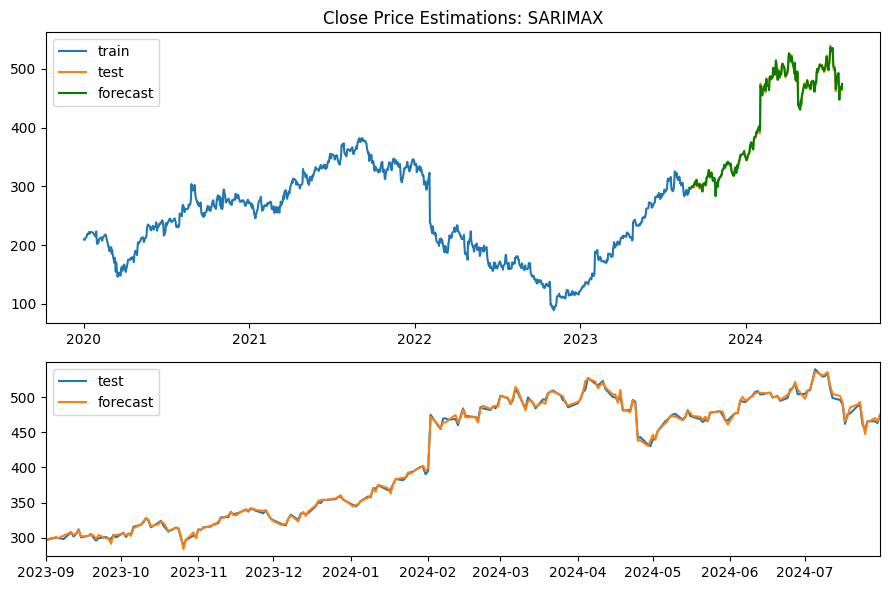

In [107]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 1]})
axes[0].plot(y_train_sarimax, label='train')
axes[0].plot(y_test_sarimax, linewidth=1.5, label='test')
axes[0].plot(forecasts, color='green', label='forecast')
axes[0].set_title('Close Price Estimations: SARIMAX')
axes[0].legend()

axes[1].plot(y_test_sarimax, linewidth=1.5, label='test')
axes[1].plot(forecasts, label='forecast')
axes[1].set_xlim(y_test_sarimax.index[0], y_test_sarimax.index[-1])
axes[1].set_ylim(min(y_test_sarimax.min(), forecasts.min()) - 10, max(y_test_sarimax.max(), forecasts.max()) + 10)
axes[1].legend()

In [108]:
def cross_val_sarimax(data, orders, seasonal_orders, k=6, test_data=True):
        '''
        Returns k-fold cross-validation score (RMSE).

        '''
        tscv = TimeSeriesSplit(n_splits=k)
        cv_scores = []
        
        for train_index, test_index in tscv.split(data):
            # set endogenous & exogenous variables
            cv_endog_train, cv_endog_test = data.iloc[train_index, -1:], data.iloc[test_index, -1:]
            cv_exog_train, cv_exog_test = data.iloc[train_index, :-1], data.iloc[test_index, :-1]
            
            mod = SARIMAX(
                endog=cv_endog_train,
                exog=cv_exog_train,
                order=orders,
                seasonal_order=seasonal_orders,
                freq='D',
                trend=None,
                enforce_stationarity=False,
                enforce_invertibility=False,
                mle_regression=True
            ).fit()
            
            # get scores & append to list
            forecasts = mod.predict(start=cv_endog_test.index[0], end=cv_endog_test.index[-1], exog=cv_exog_test, dynamic=True)
            rmse = np.sqrt(mean_squared_error(cv_endog_test, forecasts))
            cv_scores.append(rmse)
            
        return np.mean(cv_scores)

In [109]:
rmse = np.sqrt(mean_squared_error(y_test_sarimax, forecasts))
cv_rmse = cross_val_sarimax(df, orders, seasonal_orders)
r2 = r2_score(y_test_sarimax, forecasts)
mae = mean_absolute_error(y_test_sarimax, forecasts)
mape = mean_absolute_percentage_error(y_test_sarimax, forecasts)

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

In [110]:
print('Testing performance:')
print('--------------------')
print('RMSE: {:.4f}'.format(rmse))
print('6-fold CV: {:.4f}'.format(cv_rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

Testing performance:
--------------------
RMSE: 2.7048
6-fold CV: 2.4136
R2: 0.9989
MAE: 2.0341
MAPE: 0.0049%


### ***Get residual Train model LSTM***

In [155]:
residual_train = model_fit.resid
df_residual_train = pd.DataFrame(residual_train, columns=['Residual Train'])
residual_test = y_test_sarimax - forecasts
df_residual_test = pd.DataFrame(residual_test, columns=['Residual Test'])

In [156]:
print("Shape Train Sarimax = ", train_sarimax.shape)
print("Shape Test Sarimax = ", test_sarimax.shape)
print("Shape residual train = ", residual_train.shape)
print("Shape residual test = ", residual_test.shape)

Shape Train Sarimax =  (1338, 18)
Shape Test Sarimax =  (335, 18)
Shape residual train =  (1338,)
Shape residual test =  (335,)


In [157]:
residual = pd.concat([residual_train, residual_test])

In [164]:
df = pd.read_csv(r'T:\toandangquoc\iuh_project_finals\data\TSLA_All.csv')

In [165]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.fillna(0, inplace=True)
del df['Unnamed: 0']

In [166]:
df['residual'] = residual
df.head()

,close,high,low,open,volume,year,quarter,month,day,dayofweek,...,rsi,k,d,wr,cci,ppo,sentiment_numeric,esp,P/E,residual
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,209.779999,209.789993,206.270004,206.750000,1.207710e+07,2020,1,1,2,3,...,76.380818,92.364923,94.661666,-7.635077,77.658178,0.000000,1.0,0.163561,1282.579637,2.895774e-09
2020-01-03,208.669998,210.399994,206.949997,207.210007,1.118840e+07,2020,1,1,3,4,...,76.380818,92.364923,94.661666,-7.635077,77.658178,-0.042226,1.0,0.176553,1181.913237,-1.349094e-01
2020-01-04,209.980001,211.193329,206.806666,207.040003,1.314523e+07,2020,1,1,4,5,...,76.380818,92.364923,94.661666,-7.635077,77.658178,-0.024991,0.0,0.150271,1397.345602,6.540895e-01
2020-01-05,211.290003,211.986664,206.663335,206.870000,1.510207e+07,2020,1,1,5,6,...,76.380818,92.364923,94.661666,-7.635077,77.658178,0.038602,0.0,0.130799,1615.373422,1.156300e+00
2020-01-06,212.600006,212.779999,206.520004,206.699997,1.705890e+07,2020,1,1,6,0,...,76.380818,92.364923,94.661666,-7.635077,77.658178,0.137642,0.0,0.115795,1835.996698,1.607862e+00


### ***Model Lstm***

In [167]:
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model 

from keras.models import Sequential 
from keras.layers import LSTM 
from keras.layers import Dropout 
from keras.layers import Dense

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

In [168]:
df.head()

,close,high,low,open,volume,year,quarter,month,day,dayofweek,...,rsi,k,d,wr,cci,ppo,sentiment_numeric,esp,P/E,residual
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,209.779999,209.789993,206.270004,206.750000,1.207710e+07,2020,1,1,2,3,...,76.380818,92.364923,94.661666,-7.635077,77.658178,0.000000,1.0,0.163561,1282.579637,2.895774e-09
2020-01-03,208.669998,210.399994,206.949997,207.210007,1.118840e+07,2020,1,1,3,4,...,76.380818,92.364923,94.661666,-7.635077,77.658178,-0.042226,1.0,0.176553,1181.913237,-1.349094e-01
2020-01-04,209.980001,211.193329,206.806666,207.040003,1.314523e+07,2020,1,1,4,5,...,76.380818,92.364923,94.661666,-7.635077,77.658178,-0.024991,0.0,0.150271,1397.345602,6.540895e-01
2020-01-05,211.290003,211.986664,206.663335,206.870000,1.510207e+07,2020,1,1,5,6,...,76.380818,92.364923,94.661666,-7.635077,77.658178,0.038602,0.0,0.130799,1615.373422,1.156300e+00
2020-01-06,212.600006,212.779999,206.520004,206.699997,1.705890e+07,2020,1,1,6,0,...,76.380818,92.364923,94.661666,-7.635077,77.658178,0.137642,0.0,0.115795,1835.996698,1.607862e+00


In [169]:
# Check mối tương quan giữa các feature
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_regression


# split dataset into features and target
X = df.loc[:, df.columns != 'residual'].fillna(0)
y = df['residual']
# top k features
def select_kbest(k=10):
    '''
    Computes feature selection scores, correlations, p-values, and plots results.
    '''
    pearson_corr = []
    spearman_corr = []
    p_values = []

    for i in range(0, X.shape[1]):
        pearson_corr.append(pearsonr(X.iloc[:, i], y)[0])
        spearman_corr.append(spearmanr(X.iloc[:, i], y)[0])
        p_values.append(pearsonr(X.iloc[:, i], y)[1])
    
    # build feature selector
    feature_selector = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
    
    feat_scores = pd.DataFrame()
    feat_scores['Feature'] = X.columns
    feat_scores['F-score'] = feature_selector.scores_
    feat_scores['Support'] = feature_selector.get_support()
    feat_scores['Pearson'] = pearson_corr
    feat_scores['Spearman'] = spearman_corr
    feat_scores['P-value'] = p_values
    
    feat_scores.sort_values(by='F-score', ascending=False, inplace=True)
    
    return feat_scores

kbest_res = select_kbest(k=15)
kbest_res.style.hide(axis='index')

Feature,F-score,Support,Pearson,Spearman,P-value
cum_change,0.279697,True,0.414219,0.343854,0.000000
unix,0.277720,True,0.407807,0.343854,0.000000
high_close,0.234147,True,-0.496247,-0.584453,0.000000
close,0.231434,True,0.444152,0.337456,0.000000
high,0.213825,True,0.430143,0.318932,0.000000
low,0.212075,True,0.428417,0.318645,0.000000
sma_7_up,0.196963,True,0.434255,0.319006,0.000000
open,0.195665,True,0.429880,0.317581,0.000000
sma_7_low,0.195281,True,0.424933,0.318649,0.000000
ema_14,0.194995,True,0.428719,0.317452,0.000000


In [170]:
# top percent features
def select_percentile(percentile=40):
    '''
    Computes feature selection scores, correlations, p-values, and plots results.
    '''
    pearson_corr = []
    spearman_corr = []
    p_values = []

    for i in range(0, X.shape[1]):
        pearson_corr.append(pearsonr(X.iloc[:, i], y)[0])
        spearman_corr.append(spearmanr(X.iloc[:, i], y)[0])
        p_values.append(pearsonr(X.iloc[:, i], y)[1])
    
    # build feature selector
    feature_selector = SelectPercentile(score_func=mutual_info_regression, percentile=percentile).fit(X, y)
    
    feat_scores = pd.DataFrame()
    feat_scores['Feature'] = X.columns
    feat_scores['F-score'] = feature_selector.scores_
    feat_scores['Support'] = feature_selector.get_support()
    feat_scores['Pearson'] = pearson_corr
    feat_scores['Spearman'] = spearman_corr
    feat_scores['P-value'] = p_values
    
    feat_scores.sort_values(by='F-score', ascending=False, inplace=True)
    
    return feat_scores

percentile_res = select_percentile(percentile=40)
percentile_res.style.hide(axis='index')

Feature,F-score,Support,Pearson,Spearman,P-value
cum_change,0.279697,True,0.414219,0.343854,0.000000
unix,0.277742,True,0.407807,0.343854,0.000000
high_close,0.234147,True,-0.496247,-0.584453,0.000000
close,0.231512,True,0.444152,0.337456,0.000000
high,0.213803,True,0.430143,0.318932,0.000000
low,0.212121,True,0.428417,0.318645,0.000000
sma_7_up,0.196963,True,0.434255,0.319006,0.000000
open,0.195662,True,0.429880,0.317581,0.000000
sma_7_low,0.195281,True,0.424933,0.318649,0.000000
ema_14,0.194995,True,0.428719,0.317452,0.000000


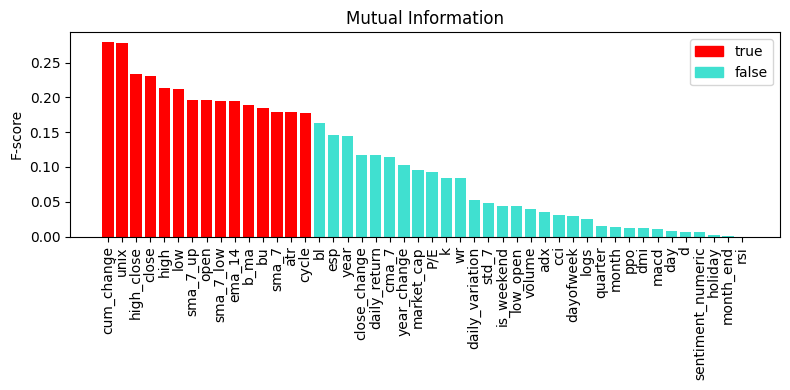

In [171]:
# mutual information results
def plot_results(data):
    '''
    Returns bar plot of scores for each feature.
    '''
    plt.figure(figsize=(8, 4), tight_layout=True)
    colors_ = ['red' if (bar == True) else 'turquoise' for bar in data['Support']]
    
    plt.bar(x=data['Feature'], height=data['F-score'], color=colors_)
    plt.title('Mutual Information')
    plt.ylabel('F-score')
    plt.xticks(rotation=90)
    
    # legend settings
    mask_colors = {'true': 'red', 'false': 'turquoise'}
    labels = list(mask_colors.keys())
    handles = [plt.Rectangle((0, 0), 1, 1, color=mask_colors[label]) for label in labels]
    plt.legend(handles, labels)
    
    plt.show()
    
plot_results(kbest_res)

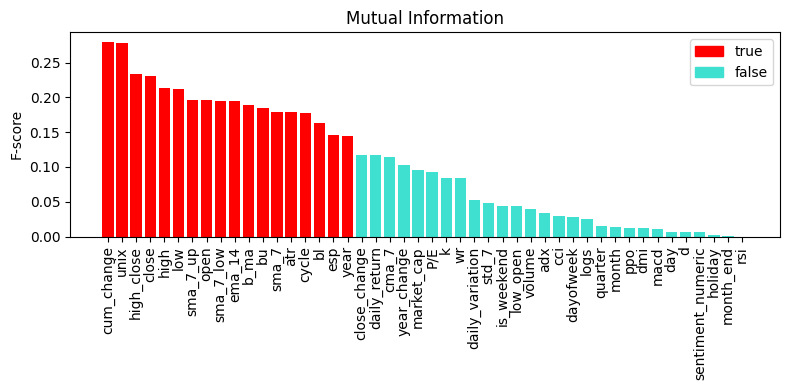

In [172]:
plot_results(percentile_res)

In [173]:
selected_features = percentile_res.query('`Support` == True')['Feature'].tolist()
selected_features.append('residual')
df_final = df.loc[:, selected_features]

In [174]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [175]:
cut_off = int(len(df_final) * split_ratio)
train = df_final[:cut_off]
test = df_final[cut_off:]
scaled_train = scaler.fit_transform(train)
print('Train shape:', scaled_train.shape)
scaled_test = scaler.fit_transform(test)
print('Test shape:', scaled_test.shape)
X_train = []
y_train = []
X_test = []
y_test = []

Train shape: (1338, 19)
Test shape: (335, 19)


In [176]:
prediction_step = 50
lstm_params = {
            'loss': 'mean_squared_error',
            'metrics': ['mean_absolute_error'],
            'optimizer': 'adam',
            'lstm_units': 64,
            'epochs': 50,
            'batch_size': 10,
            'validation_split': 0.1
        }

In [177]:
test_length = len(df_final) - cut_off
for i in range(prediction_step, cut_off):
    X_train.append(scaled_train[i - prediction_step:i, 0:scaled_train.shape[1]])
    y_train.append(scaled_train[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)

X_train shape : (1288, 50, 19)
y_train shape : (1288, 1)


In [178]:
for i in range(prediction_step, test_length):
            X_test.append(scaled_test[i - prediction_step:i, 0:scaled_test.shape[1]])
            y_test.append(scaled_test[i, -1])
X_test, y_test = np.array(X_test), np.array(y_test)
y_test = np.reshape(y_test, (-1, 1))
        
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_test shape : (285, 50, 19)
y_test shape : (285, 1)


In [179]:
model = Sequential(
            [
                # 1st LSTM layer
                LSTM(units=lstm_params['lstm_units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
                
                # 2nd layer
                LSTM(units=lstm_params['lstm_units'], return_sequences=False),
                
                Dense(units=32),
                
                # output layer
                Dense(units=1)
                #Dense(units=y_train.shape[1]) # 1-size output
                
            ], name='LSTM_model'
        )
        
model.compile(optimizer=lstm_params['optimizer'], loss=lstm_params['loss'])

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [180]:
lstm_history = model.fit(
                        x=X_train,
                        y=y_train,
                        epochs=lstm_params['epochs'],
                        batch_size=lstm_params['batch_size'],
                        verbose=1,
                        callbacks=None
                        )

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0270
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0115
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0112
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0114
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0127
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - loss: 0.0114
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - loss: 0.0124
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.0119
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.0115
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.0127
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.0119
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.0117
Epoch 13/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.0115
Epoch 14/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.0105
Epoch 15/50
129/129 ━━━━━━━━━━━━━━

In [181]:
lstm_predictions = model.predict(X_test)
prediction_copies = np.repeat(lstm_predictions, test.shape[1], axis=-1)
lstm_pred = scaler.inverse_transform(prediction_copies)[:, -1]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [182]:
lstm_pred.shape, forecasts.shape

((285,), (335,))

In [184]:
forecasts[51]

C:\Users\DANG QUOC TOAN\AppData\Local\Temp\ipykernel_1092\863179429.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts[51]


308.3386555227299

In [185]:
forecasts[50:] = forecasts[50:] + lstm_pred 

In [186]:
forecasts[51]

C:\Users\DANG QUOC TOAN\AppData\Local\Temp\ipykernel_1092\863179429.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts[51]


310.91442137088967

In [187]:
rmse = np.sqrt(mean_squared_error(y_test_sarimax, forecasts))
r2 = r2_score(y_test_sarimax, forecasts)
mae = mean_absolute_error(y_test_sarimax, forecasts)
mape = mean_absolute_percentage_error(y_test_sarimax, forecasts)

In [188]:
print('Testing performance:')
print('--------------------')
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

Testing performance:
--------------------
RMSE: 3.2094
R2: 0.9985
MAE: 2.5755
MAPE: 0.0063%
